# SNN class

In [7]:
import numpy as np
from scipy.interpolate import interp1d
from typing import List, Tuple

# --- 1. Mollification & Kernels ---

class GaussianKernel:
    """Gaussian kernel approximation for spikes."""
    def __init__(self, mu: float = 0.05):
        self.mu = mu
        self.coef = 1.0 / (mu * np.sqrt(2 * np.pi))
    
    def __call__(self, t: float, spike_times: List[float]) -> float:
        if not spike_times:
            return 0.0
        ts = np.array(spike_times)
        return np.sum(self.coef * np.exp(-0.5 * ((t - ts) / self.mu) ** 2))

class MollifiedReset:
    """Mollified Reset: D_zeta(s) = (1 - H(s-theta)) * s"""
    def __init__(self, zeta: float = 10.0):
        self.zeta = zeta
    
    def H(self, s: float) -> float:
        arg = np.clip(self.zeta * s / 2.0, -20, 20)
        return 0.5 * (1.0 + np.tanh(arg))
    
    def D(self, s: float, theta: float) -> float:
        return (1.0 - self.H(s - theta)) * s
    
    def dD_ds(self, s: float, theta: float) -> float:
        arg = np.clip(self.zeta * (s - theta) / 2.0, -20, 20)
        sech2 = (1.0 / np.cosh(arg))**2
        dH_ds = 0.25 * self.zeta * sech2
        H_val = self.H(s - theta)
        return (1.0 - H_val) - s * dH_ds

# --- 2. Network Configuration ---

class NetworkConfig:
    def __init__(self, d: int = 10, n_timepoints: int = 240, T_train: float = 2.4, 
                 L: int = 1, P: int = 5, n_classes: int = 2):
        self.d = d
        self.n_timepoints = n_timepoints
        self.T_train = T_train
        self.dt = T_train / n_timepoints
        self.L = L
        self.P = P
        self.n_classes = n_classes
        self.tau_v = 0.1
        self.tau_u = 0.1
        self.theta_h = 0.5
        self.n_state = (L * P) + n_classes

# --- 3. SNN Dynamics ---

class SNNDynamics:
    def __init__(self, config: NetworkConfig):
        self.config = config
        self.kernel = GaussianKernel(mu=0.05)
        self.reset = MollifiedReset(zeta=1.0)
        self.t_grid = np.linspace(0, config.T_train, config.n_timepoints)
        
        # Weights
        self.omega = []
        scale = 0.1
        self.omega.append(np.random.randn(config.P, config.d) * scale) # Input -> Hidden
        for _ in range(config.L - 1):
            self.omega.append(np.random.randn(config.P, config.P) * scale)
            
        self.w = np.random.randn(config.n_classes, config.P) * scale # Hidden -> Output
        self.nu = np.random.randn(config.n_classes) * scale # Readout
        
        self.spike_times = [[[] for _ in range(config.P)] for _ in range(config.L)]

    def update_zeta(self, epoch: int, total_epochs: int):
        start_z, end_z = 1.0, 20.0
        if total_epochs > 1:
            self.reset.zeta = start_z + (end_z - start_z) * (epoch / (total_epochs - 1))
        else:
            self.reset.zeta = end_z

    def get_params(self):
        return {'omega': self.omega, 'w': self.w, 'nu': self.nu}

    def simulate(self, X_data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        cfg = self.config
        steps = len(self.t_grid)
        dt = cfg.dt
        X = np.zeros((steps, cfg.n_state))
        self.spike_times = [[[] for _ in range(cfg.P)] for _ in range(cfg.L)]
        input_interp = interp1d(self.t_grid, X_data, axis=1, fill_value="extrapolate")
        
        for i in range(steps - 1):
            t = self.t_grid[i]
            curr = X[i]
            inp = input_interp(t)
            dX = np.zeros(cfg.n_state)
            idx = 0
            
            # Hidden
            for ell in range(cfg.L):
                for p in range(cfg.P):
                    xi = curr[idx]
                    if ell == 0:
                        J_val = np.dot(self.omega[0][p], inp)
                    else:
                        J_val = 0.0
                        for q in range(cfg.P):
                            J_val += self.omega[ell][p, q] * self.kernel(t, self.spike_times[ell-1][q])
                    dX[idx] = (-xi + J_val) / cfg.tau_v
                    idx += 1
            
            # Output
            for c in range(cfg.n_classes):
                u_val = curr[idx]
                Phi_sum = 0.0
                for q in range(cfg.P):
                    Phi_sum += self.w[c, q] * self.kernel(t, self.spike_times[-1][q])
                dX[idx] = (-u_val + Phi_sum) / cfg.tau_u
                idx += 1
            
            X[i+1] = curr + dX * dt
            
            # Reset
            idx = 0
            for ell in range(cfg.L):
                for p in range(cfg.P):
                    val = X[i+1, idx]
                    if val >= cfg.theta_h:
                        if len(self.spike_times[ell][p]) == 0 or (t - self.spike_times[ell][p][-1] > 0.05):
                            self.spike_times[ell][p].append(t)
                    X[i+1, idx] = self.reset.D(val, cfg.theta_h)
                    idx += 1
                    
        return self.t_grid, X

    def predict(self, X_final: np.ndarray) -> np.ndarray:
        u_T = X_final[-self.config.n_classes:]
        logits = self.nu * u_T
        exps = np.exp(logits - np.max(logits))
        return exps / np.sum(exps)

# shooting

In [8]:
import numpy as np

class AdjointShootingSolver:
    """
    Solves BVP: dot_lambda = -J^T lambda, lambda(T) = Target.
    Uses Secant Method on the Residual R = lambda(T)_sim - lambda(T)_target.
    """
    def __init__(self, snn: SNNDynamics):
        self.snn = snn
        self.config = snn.config
        
    def _adjoint_dynamics(self, t, lam, X_curr):
        cfg = self.config
        dLam = np.zeros_like(lam)
        idx = 0
        
        # Hidden
        for ell in range(cfg.L):
            for p in range(cfg.P):
                xi = X_curr[idx]
                lam_val = lam[idx]
                reset_deriv = self.snn.reset.dD_ds(xi, cfg.theta_h)
                
                # Forward Adjoint Logic (Expansive/Unstable direction)
                # Term: - (-1/tau * reset_deriv) * L = 1/tau * reset_deriv * L
                term = (-1.0/cfg.tau_v) * reset_deriv
                dLam[idx] = - (term * lam_val)
                idx += 1
                
        # Output
        for c in range(cfg.n_classes):
            dLam[idx] = - (lam[idx] * (-1.0/cfg.tau_u))
            idx += 1
            
        return dLam

    def integrate_forward(self, lambda_0, X_traj):
        steps = len(X_traj)
        dt = self.config.dt
        L = np.zeros((steps, self.config.n_state))
        L[0] = lambda_0
        curr_L = lambda_0.copy()
        
        for i in range(steps - 1):
            t = self.snn.t_grid[i]
            dLam = self._adjoint_dynamics(t, curr_L, X_traj[i])
            curr_L += dLam * dt
            L[i+1] = curr_L
        return L

    def solve(self, X_traj, lambda_T_target, max_iter=30, tol=1e-5):
        n_state = self.config.n_state
        
        # Guesses
        lam_a = np.zeros(n_state)
        traj_a = self.integrate_forward(lam_a, X_traj)
        res_a = traj_a[-1] - lambda_T_target
        
        lam_b = np.random.randn(n_state) * 0.01
        traj_b = self.integrate_forward(lam_b, X_traj)
        res_b = traj_b[-1] - lambda_T_target
        
        history = [] # Stores residuals
        
        for k in range(max_iter):
            norm_res = np.linalg.norm(res_b)
            history.append(norm_res)
            
            if norm_res < tol:
                return traj_b, history
            
            # Secant Update
            denom = res_b - res_a
            denom[np.abs(denom) < 1e-9] = 1e-9
            
            update = res_b * (lam_b - lam_a) / denom
            lam_new = lam_b - 0.5 * update # Damped
            
            lam_a, res_a = lam_b, res_b
            lam_b = lam_new
            traj_b = self.integrate_forward(lam_b, X_traj)
            res_b = traj_b[-1] - lambda_T_target
            
        return traj_b, history

class GradientSolver:
    """Stable Backward Adjoint Solver for Training."""
    def __init__(self, snn):
        self.snn = snn
        
    def solve_backward(self, X_traj, lambda_T):
        cfg = self.snn.config
        steps = len(X_traj)
        dt = cfg.dt
        L = np.zeros((steps, cfg.n_state))
        curr_L = lambda_T.copy()
        L[-1] = curr_L
        
        for i in range(steps-2, -1, -1):
            dLam = np.zeros_like(curr_L)
            idx = 0
            for ell in range(cfg.L):
                for p in range(cfg.P):
                    xi = X_traj[i][idx]
                    lam_val = curr_L[idx]
                    reset_deriv = self.snn.reset.dD_ds(xi, cfg.theta_h)
                    dLam[idx] = (1.0/cfg.tau_v) * reset_deriv * lam_val
                    idx += 1
            for c in range(cfg.n_classes):
                dLam[idx] = (1.0/cfg.tau_u) * curr_L[idx]
                idx += 1
            curr_L -= dLam * dt
            L[i] = curr_L
        return L

    def compute_gradients(self, X_in, y_target, X_traj):
        cfg = self.snn.config
        dt = cfg.dt
        steps = len(X_traj)
        
        probs = self.snn.predict(X_traj[-1])
        dJ_du = probs.copy()
        dJ_du[y_target] -= 1.0
        
        lambda_T = np.zeros(cfg.n_state)
        lambda_T[-cfg.n_classes:] = dJ_du
        
        lambda_traj = self.solve_backward(X_traj, lambda_T)
        
        grad_omega = [np.zeros_like(om) for om in self.snn.omega]
        grad_w = np.zeros_like(self.snn.w)
        grad_nu = dJ_du * 0.1
        
        # Input Weights: Outer Product
        lambda_hidden_0 = lambda_traj[:, 0:cfg.P].T
        grad_omega[0] = np.einsum('pt,dt->pd', lambda_hidden_0, X_in) * dt
        
        # Output Weights
        lambda_out = lambda_traj[:, -cfg.n_classes:].T
        hidden_activity = np.zeros((cfg.P, steps))
        for q in range(cfg.P):
            for t_k in range(steps):
                hidden_activity[q, t_k] = self.snn.kernel(self.snn.t_grid[t_k], self.snn.spike_times[-1][q])
        grad_w = np.einsum('ct,pt->cp', lambda_out, hidden_activity) * dt
        
        return grad_omega, grad_w, grad_nu

# visual

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# High Contrast Palette (Accesible)
C_TRAINED = '#0077BB'  # Azul (Entrenado)
C_LINEAR = '#EE3377'   # Magenta (Inicial/Lineal)
C_ACC = '#009988'      # Turquesa (Precisión)
C_LOSS = '#CC3311'     # Rojo (Pérdida)
C_GRID = '#BBBBBB'

plt.style.use('default')

def save_plot(filename):
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# 1. Shooting Method Convergence
def plot_shooting_convergence(history, filename='shooting_convergence.png'):
    iterations = np.arange(len(history))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(iterations, history, marker='o', linewidth=3, color=C_TRAINED, label='Residual Norm')
    
    ax.set_title("Convergencia del Método de Disparo (Secante)", fontweight='bold', fontsize=14)
    ax.set_xlabel("Iteración", fontsize=12)
    ax.set_ylabel("Residuo Terminal ||λ(T) - Target||", fontsize=12)
    ax.set_yscale('log')
    ax.grid(True, which="both", color=C_GRID, linestyle='--', alpha=0.5)
    
    save_plot(filename)

# 2. Confusion Matrix & Metrics
def plot_confusion_matrix_metrics(y_true, y_pred, filename='confusion_matrix.png'):
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    classes = np.unique(y_true)
    
    fig = plt.figure(figsize=(14, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1])
    
    # Heatmap
    ax_cm = fig.add_subplot(gs[0])
    im = ax_cm.imshow(cm, interpolation='nearest', cmap='Blues')
    ax_cm.set_title('Matriz de Confusión', fontweight='bold', fontsize=14)
    fig.colorbar(im, ax=ax_cm, fraction=0.046, pad=0.04)
    
    tick_marks = np.arange(len(classes))
    ax_cm.set_xticks(tick_marks)
    ax_cm.set_yticks(tick_marks)
    ax_cm.set_xticklabels(classes, fontsize=12)
    ax_cm.set_yticklabels(classes, fontsize=12)
    ax_cm.set_ylabel('Etiqueta Real', fontsize=12)
    ax_cm.set_xlabel('Predicción', fontsize=12)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax_cm.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", 
                 fontweight='bold', fontsize=14)
                 
    # Metrics Panel
    ax_txt = fig.add_subplot(gs[1])
    ax_txt.axis('off')
    
    metrics_str = "Métricas de Desempeño\n"
    metrics_str += "=====================\n\n"
    metrics_str += f"Exactitud (Accuracy): {report['accuracy']:.4f}\n\n"
    
    macro = report['macro avg']
    metrics_str += f"Precisión: {macro['precision']:.4f}\n"
    metrics_str += f"Recall:    {macro['recall']:.4f}\n"
    metrics_str += f"F1-Score:  {macro['f1-score']:.4f}\n"
    
    ax_txt.text(0.1, 0.5, metrics_str, fontsize=16, family='monospace', va='center')
    
    save_plot(filename)

# 3. Adjoint Contrast
def plot_adjoint_contrast(t, lam_backward, lam_shooting, filename='adjoint_contrast.png'):
    idx = np.argmax(np.std(lam_backward, axis=0))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(t, lam_backward[:, idx], color=C_TRAINED, linewidth=3, label='Entrenado (Backward Stable)')
    ax.plot(t, lam_shooting[:, idx], color=C_LINEAR, linestyle='--', linewidth=3, label='Método de Disparo (PMP)')
    
    ax.set_title(f"Contraste de Trayectorias Adjuntas (Neurona {idx})", fontweight='bold', fontsize=14)
    ax.set_xlabel("Tiempo (s)", fontsize=12)
    ax.set_ylabel("Valor Adjunto λ(t)", fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, color=C_GRID, linestyle='--', alpha=0.5)
    
    save_plot(filename)

# 4. Neuron Dynamics
def plot_dynamics_contrast(t, X_init, X_trained, filename='dynamics_contrast.png'):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Hidden
    axes[0].plot(t, X_init[:, 0], color=C_LINEAR, linestyle='--', linewidth=2, label='Inicial (Sin entrenar)')
    axes[0].plot(t, X_trained[:, 0], color=C_TRAINED, linewidth=2, label='Entrenado')
    axes[0].set_ylabel("Potencial Oculto V(t)", fontsize=12)
    axes[0].set_title("Dinámica Neurona Oculta", fontweight='bold')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    
    # Output
    axes[1].plot(t, X_init[:, -1], color=C_LINEAR, linestyle='--', linewidth=2, label='Inicial')
    axes[1].plot(t, X_trained[:, -1], color=C_TRAINED, linewidth=2, label='Entrenado')
    axes[1].set_ylabel("Potencial Salida U(t)", fontsize=12)
    axes[1].set_xlabel("Tiempo (s)", fontsize=12)
    axes[1].set_title("Dinámica Neurona Salida", fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    save_plot(filename)

# 5. Input Data
def plot_input_samples(X_data, y_data, filename='input_samples.png'):
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    fig.suptitle("Muestras de Datos de Entrada (Pulsos)", fontweight='bold', fontsize=14)
    
    for i in range(3):
        im = axes[i].imshow(X_data[i], aspect='auto', cmap='magma', interpolation='nearest')
        axes[i].set_ylabel(f"Clase {y_data[i]}", fontsize=10)
    
    axes[-1].set_xlabel("Paso de Tiempo", fontsize=12)
    plt.tight_layout()
    save_plot(filename)

# Extra: Training History
def plot_training_history(history, filename='training_history.png'):
    epochs = [h['epoch'] for h in history]
    loss = [h['loss'] for h in history]
    acc = [h['acc'] for h in history]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.set_xlabel('Época', fontsize=12)
    ax1.set_ylabel('Pérdida (Loss)', color=C_LOSS, fontsize=12)
    ax1.plot(epochs, loss, color=C_LOSS, linewidth=3, marker='o', label='Pérdida')
    ax1.tick_params(axis='y', labelcolor=C_LOSS)
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Exactitud (Accuracy)', color=C_ACC, fontsize=12)
    ax2.plot(epochs, acc, color=C_ACC, linewidth=3, marker='s', label='Exactitud')
    ax2.tick_params(axis='y', labelcolor=C_ACC)
    
    plt.title("Historial de Entrenamiento", fontweight='bold', fontsize=14)
    fig.tight_layout()
    save_plot(filename)

# execute

=== SNN Shooting Method & Training Analysis ===
Loaded Data: X (1388, 10, 240), y (1388,)
Capturing Initial Dynamics...
Starting Training (1110 samples)...
Epoch 1: Loss 0.6931, Acc 0.6901, Time 77.21s
Epoch 2: Loss 0.6931, Acc 0.6901, Time 65.13s
Epoch 3: Loss 0.6931, Acc 0.6901, Time 69.24s
Epoch 4: Loss 0.6931, Acc 0.6901, Time 68.80s
Epoch 5: Loss 0.6931, Acc 0.6901, Time 64.71s


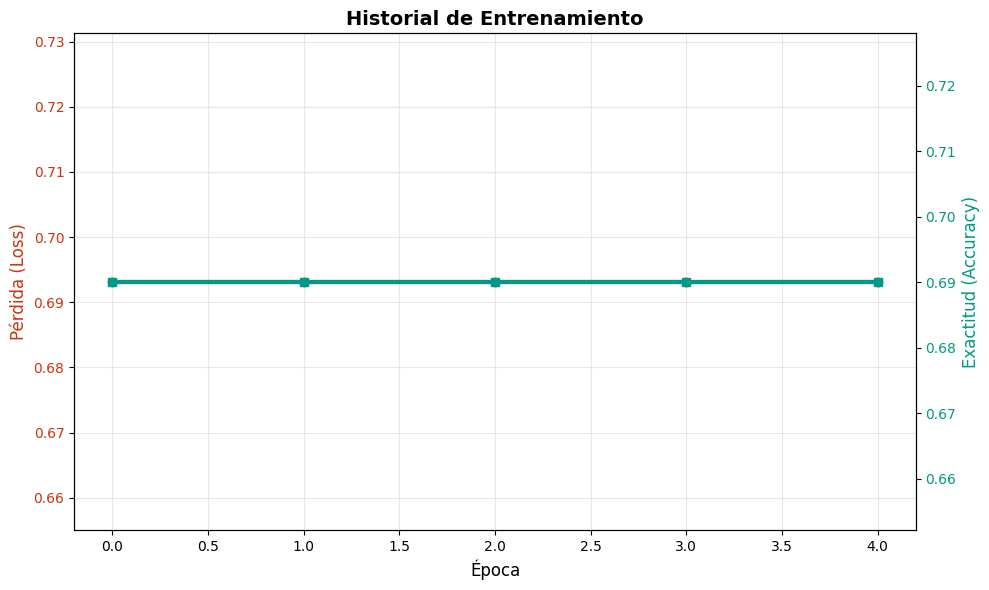

Evaluating Test Set...


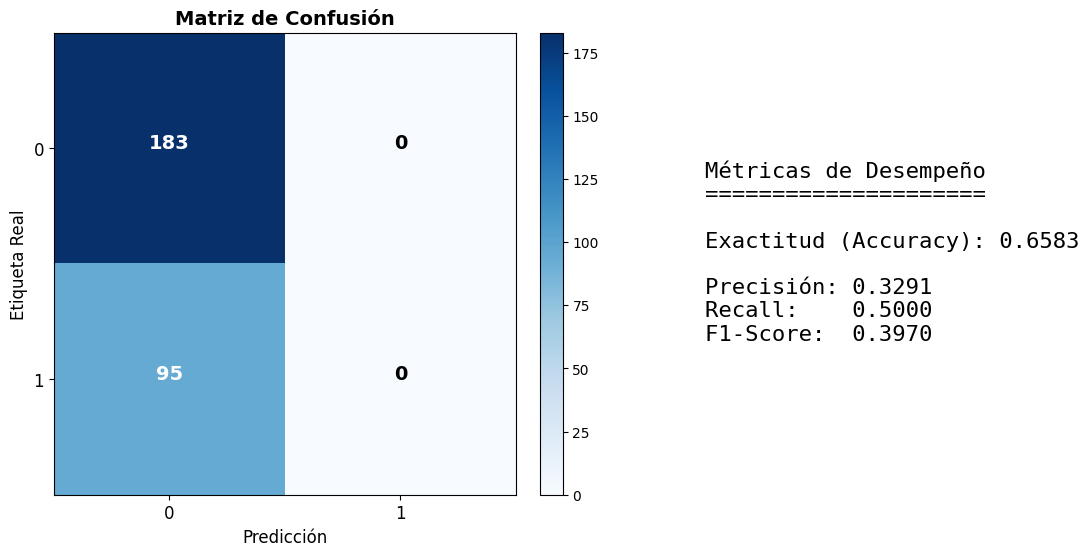

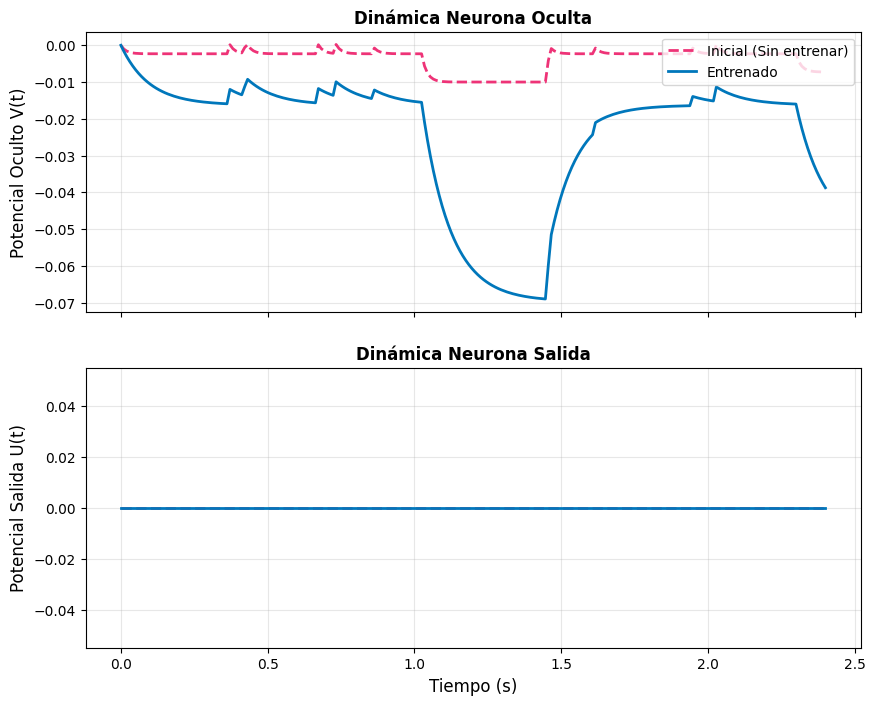

Running PMP Shooting Diagnostic...


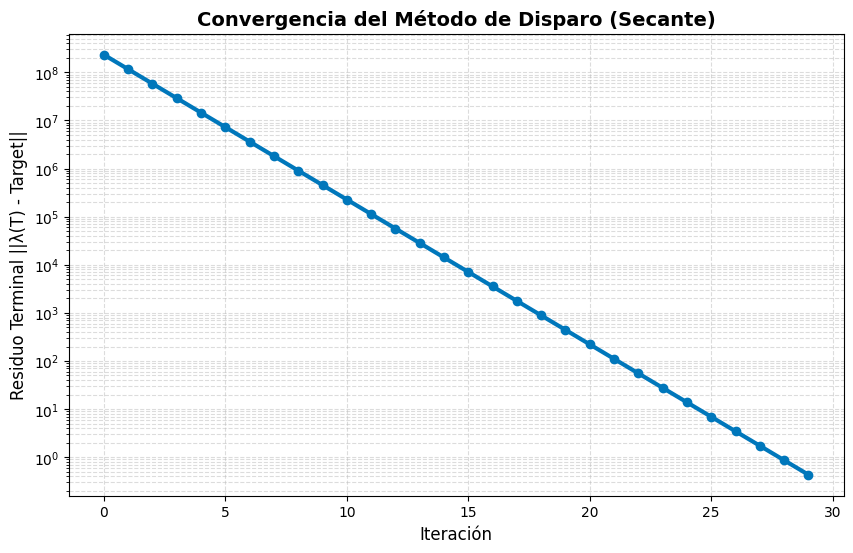

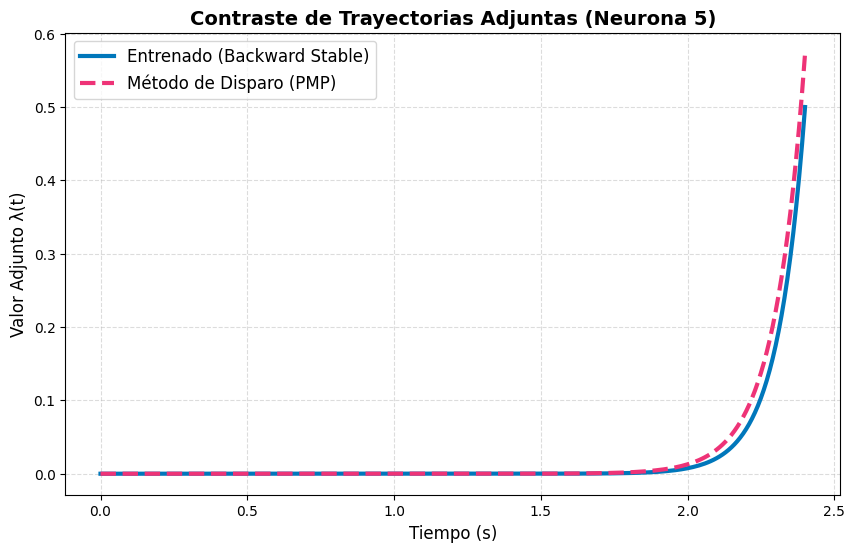

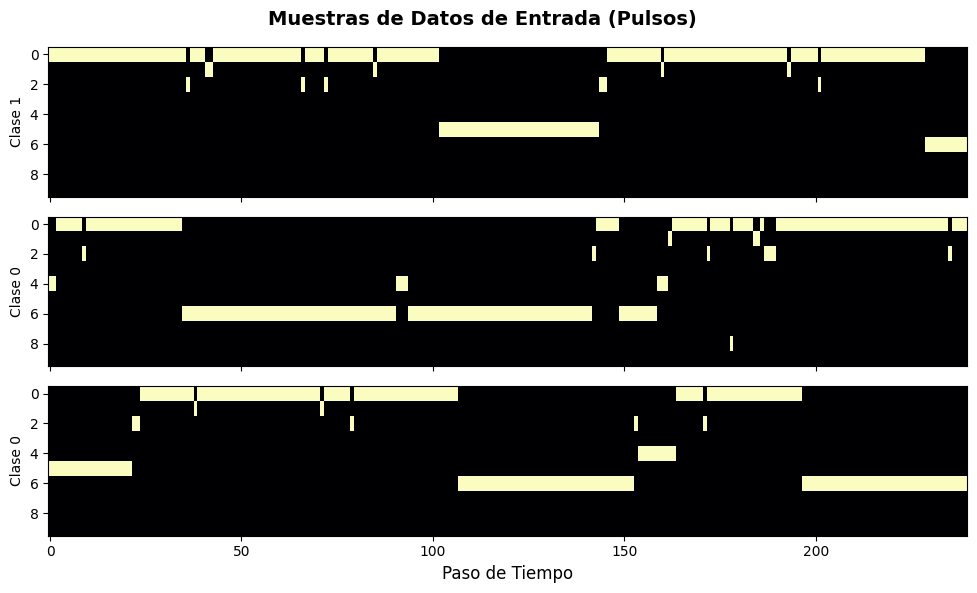

Analysis Complete. All 5 plots generated.


In [13]:
import numpy as np
import time
from sklearn.model_selection import train_test_split

def main():
    print("=== SNN Shooting Method & Training Analysis ===")
    
    # 1. Load Data
    try:
        X_full = np.load('X.npy')
        y_full = np.load('y.npy')
        print(f"Loaded Data: X {X_full.shape}, y {y_full.shape}")
    except FileNotFoundError:
        print("Data not found. Generating Mock Data (200 samples).")
        X_full = np.abs(np.random.randn(200, 10, 240))
        y_full = np.random.randint(0, 2, 200)
    
    # 2. Config & Setup
    config = NetworkConfig(d=10, n_timepoints=240, T_train=2.4, L=1, P=5, n_classes=2)
    snn = SNNDynamics(config)
    grad_solver = GradientSolver(snn)
    
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
    
    # Capture Initial State (for Plot 4)
    print("Capturing Initial Dynamics...")
    test_sample_idx = 0
    t_grid, X_init_traj = snn.simulate(X_test[test_sample_idx])
    
    # 3. Training Loop
    print(f"Starting Training ({len(X_train)} samples)...")
    n_epochs = 5
    lr = 0.05
    history = []
    
    for epoch in range(n_epochs):
        start_t = time.time()
        snn.update_zeta(epoch, n_epochs)
        
        total_loss = 0.0
        correct = 0
        
        for i in range(len(X_train)):
            X_in = X_train[i]
            y_target = int(y_train[i])
            
            _, X_traj = snn.simulate(X_in)
            
            # Update via Backward Adjoint
            g_omega, g_w, g_nu = grad_solver.compute_gradients(X_in, y_target, X_traj)
            
            for l in range(len(snn.omega)):
                snn.omega[l] -= lr * g_omega[l]
            snn.w -= lr * g_w
            snn.nu -= lr * g_nu
            
            # Metrics
            probs = snn.predict(X_traj[-1])
            total_loss += -np.log(probs[y_target] + 1e-10)
            if np.argmax(probs) == y_target: correct += 1
            
        acc = correct / len(X_train)
        loss = total_loss / len(X_train)
        history.append({'epoch': epoch, 'loss': loss, 'acc': acc})
        print(f"Epoch {epoch+1}: Loss {loss:.4f}, Acc {acc:.4f}, Time {time.time()-start_t:.2f}s")
    
    # Plot Training History
    plot_training_history(history)
    
    # 4. Evaluation & Confusion Matrix (Plot 2)
    print("Evaluating Test Set...")
    y_pred = []
    for i in range(len(X_test)):
        _, X_traj = snn.simulate(X_test[i])
        probs = snn.predict(X_traj[-1])
        y_pred.append(np.argmax(probs))
    
    plot_confusion_matrix_metrics(y_test, y_pred)
    
    # 5. Capture Trained Dynamics (Plot 4)
    _, X_trained_traj = snn.simulate(X_test[test_sample_idx])
    plot_dynamics_contrast(t_grid, X_init_traj, X_trained_traj)
    
    # 6. PMP Shooting Method Diagnostics (Plots 1 & 3)
    print("Running PMP Shooting Diagnostic...")
    
    # Use the specific test sample
    X_target_sample = X_test[test_sample_idx]
    y_target_val = int(y_test[test_sample_idx])
    
    # Forward Simulation (Reference)
    _, X_ref = snn.simulate(X_target_sample)
    
    # Define Target Adjoint Boundary
    probs = snn.predict(X_ref[-1])
    dJ_du = probs.copy()
    dJ_du[y_target_val] -= 1.0
    lambda_T = np.zeros(config.n_state)
    lambda_T[-config.n_classes:] = dJ_du
    
    # Solve Backward (Ground Truth)
    lam_backward = grad_solver.solve_backward(X_ref, lambda_T)
    
    # Solve Forward via Shooting
    shooter = AdjointShootingSolver(snn)
    lam_shooting, shoot_history = shooter.solve(X_ref, lambda_T)
    
    plot_shooting_convergence(shoot_history)
    plot_adjoint_contrast(t_grid, lam_backward, lam_shooting)
    
    # 7. Input Samples (Plot 5)
    plot_input_samples(X_test[:3], y_test[:3])
    
    print("Analysis Complete. All 5 plots generated.")

if __name__ == "__main__":
    main()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c7d4307c-0ebe-4a0e-91ec-84ab60ddfdb3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>